# INIT

In [88]:
!pip install python-chess -q
!pip install opendatasets -q
import chess
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import torch, torchvision
import copy
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import time

from sklearn.metrics import confusion_matrix
from IPython.display import SVG, display
#! pip install kaggle -q 
#! kaggle datasets download arevel/chess-games -q


In [16]:
#!unzip -qq ./chess-games.zip

In [17]:
board=chess.Board()
#print(board)

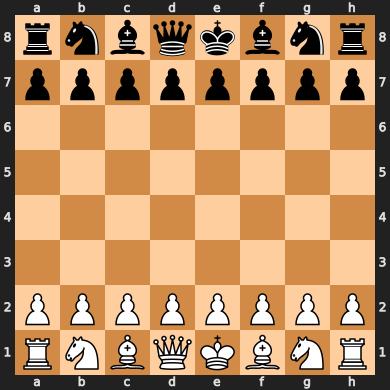

In [18]:
board

In [19]:
"""for move in board.legal_moves:
    print(move)"""

'for move in board.legal_moves:\n    print(move)'

In [20]:
#board.push_san('c2c3')

In [21]:
"""for move in board.legal_moves:
    print(move)
    """

'for move in board.legal_moves:\n    print(move)\n    '

In [22]:
#print(board.outcome())

In [23]:
#board.fen()

In [24]:
def play_random(fen):
    board=chess.Board(fen=fen)
    move = random.choice(list(board.legal_moves))
    return str(move)

In [25]:
def one_hot_encode_pieces(piece):
    pieces = list('rnbqkpRNBQKP.')
    arr = np.zeros(len(pieces))
    piece_to_index = {p: i for i, p in enumerate(pieces)}
    index = piece_to_index[piece]
    arr[index] = 1
    return arr

In [26]:
def encode_board(board):
    board_str=str(board)
    board_str=board_str.replace(' ','')
    board_list=[]
    for row in board_str.split('\n'):
        row_list=[]
        for piece in row:
            row_list.append(one_hot_encode_pieces(piece))
        board_list.append(row_list)
    return np.array(board_list)
encode_board(chess.Board())
    

array([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

    

In [27]:
train_df= pd.read_csv('./train.csv',index_col='id')
train_df=train_df[:10000]
val_df=train_df[-1000:]
train_df.head()

,board,black_score,best_move
id,,,
80091,6R1/8/5K2/8/5k2/8/8/2r5 w - - 89 118,0.0,g8d8
18578,r1bn1rk1/1p2b1p1/1q2p2p/p2p1p1n/P2P3P/2PB1N2/1...,-131.0,f3e5
11580,r2qkb1r/2p2pp1/p1n2nP1/1p1p3p/P7/1Q5b/1PP1PPB1...,-490.0,g6f7
72805,8/4kp2/R6p/8/4K3/8/8/8 b - - 7 85,-574.0,h6h5
74310,8/8/k7/4R3/8/6K1/8/1r6 w - - 99 90,0.0,e5e6


In [57]:
def encode_fen_string(fen_str):
    board=chess.Board(fen=fen_str)
    return encode_board(board)
X_train = np.stack(train_df['board'].apply(encode_fen_string))
y_train = train_df['black_score']


X_val = np.stack(val_df['board'].apply(encode_fen_string))
y_val = val_df['black_score']

In [58]:
"""
model=torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(128,1),
    torch.nn.ReLU(),
    #torch.nn.Linear(1),
)
opt_model=torch.compile(model)

"""

In [105]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# With the Keras Sequential model we can stack neural network layers together
model = Sequential([
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1),
])

model.compile(
    optimizer='rmsprop',
    loss='mean_squared_error',
    metrics=['accuracy'])



In [106]:
checkpoint_filepath = 'Schachmodelle/checkpoint.model.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

In [109]:
history=model.fit(
    X_train,
    y_train,
    epochs=2000,
    validation_data=(X_val,y_val),
    callbacks=[model_checkpoint_callback])
timer=str(int(time.time()))
model.save('Schach_Ordner/my_model'+timer+'.keras')


Epoch 1/2000
313/313 [==============================] - 1s 2ms/step - loss: 110030.9219 - accuracy: 0.0675 - val_loss: 101930.3906 - val_accuracy: 0.0640
Epoch 2/2000
313/313 [==============================] - 0s 2ms/step - loss: 109211.4453 - accuracy: 0.0692 - val_loss: 102089.9062 - val_accuracy: 0.0520
Epoch 3/2000
313/313 [==============================] - 0s 2ms/step - loss: 108466.5859 - accuracy: 0.0659 - val_loss: 100053.6953 - val_accuracy: 0.0730
Epoch 4/2000
313/313 [==============================] - 0s 1ms/step - loss: 107706.1094 - accuracy: 0.0685 - val_loss: 99442.3125 - val_accuracy: 0.0770
Epoch 5/2000
313/313 [==============================] - 0s 1ms/step - loss: 107080.4766 - accuracy: 0.0665 - val_loss: 99666.6328 - val_accuracy: 0.0590
Epoch 6/2000
313/313 [==============================] - 0s 1ms/step - loss: 106407.0781 - accuracy: 0.0677 - val_loss: 98071.7812 - val_accuracy: 0.0770
Epoch 7/2000
313/313 [==============================] - 0s 1ms/step - loss: 105

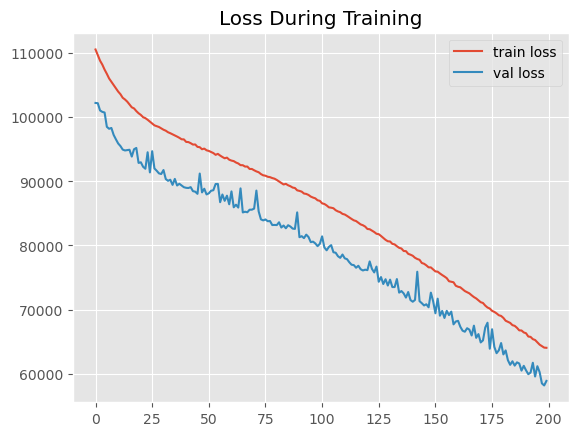

In [91]:
plt.style.use('ggplot')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss During Training')
plt.show()


In [75]:
def play_nn(fen,show_move_evaluations=False):
    board=chess.Board(fen=fen)
    moves=[]
    input_vectors=[]
    for move in board.legal_moves:
        candidate_board=board.copy()
        candidate_board.push(move)
        moves.append(move)
        input_vectors.append(encode_board(str(candidate_board)).astype(np.int32).flatten())
    input_vectors=np.stack(input_vectors)
    scores=model.predict(input_vectors,verbose=0)
    if board.turn==chess.BLACK:
        index_of_best_move=np.argmax(scores)
    else:
        index_of_best_move=np.argmax(-scores)
    if show_move_evaluations:
        print(zip(moves,scores))
    best_move=moves[index_of_best_move]
    return str(best_move)
        

In [76]:
play_nn(chess.Board().fen())

'g1f3'

In [79]:
test_df=pd.read_csv('test.csv')
test_df.head()


,id,board
0,7937,r1bqk2r/pp2bpp1/2n1pn1p/2pp4/3P1B2/2P1PN2/PP1N...
1,20035,2r2k1r/pp2pp1p/1q3npb/1B1N4/8/P4Q1P/1P3PP1/R2R...
2,71263,3b4/8/5k2/5p2/8/4K3/8/5B2 b - - 2 80
3,61997,5k2/R7/3r3p/2PP2pP/5pb1/P1K5/6B1/8 w - - 1 61
4,26510,r3r1k1/pb3p1p/1p1q2p1/3P1p2/3Q1P2/5N2/PP4PP/3R...


In [81]:
test_df['best_move']=test_df['board'].apply(play_nn)

In [83]:
test_df['best_move']

0      c5c4
1      f3b3
2      f6e6
3      a7a8
4      b7d5
       ... 
195    b4b3
196    g5g4
197    c3d4
198    f3f4
199    b8c8
Name: best_move, Length: 200, dtype: object

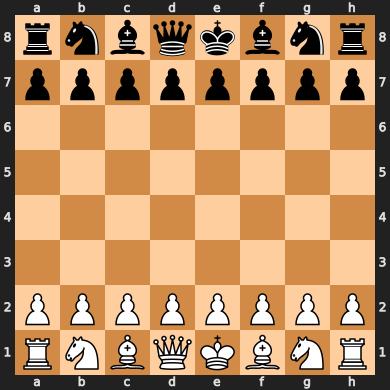

KeyboardInterrupt: Interrupted by user

In [77]:
def play_game(ai_function):
    board = chess.Board()

    while board.outcome() is None:
        # We print out the board as an SVG
        display(SVG(board._repr_svg_()))

        # If it's white's turn, we have the user play
        if board.turn == chess.WHITE:
            user_move = input('Your move: ')
            if user_move == 'quit':
                break
            # The move a user puts in isn't a valid move, we keep prompting them for a valid move
            while user_move not in [str(move) for move in board.legal_moves]:
                print('That wasn\'t a valid move. Please enter a move in Standard Algebraic Notation')
                user_move = input('Your move: ')
            board.push_san(user_move)

        # If it's black's turn, we have the AI play
        elif board.turn == chess.BLACK:
            ai_move = ai_function(board.fen())
            print(f'AI move: {ai_move}')
            board.push_san(ai_move)
    print(board.outcome())
        
play_game(play_random)

In [102]:
print("Fit model on training data")
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=2,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_val, y_val),
)


Fit model on training data
Epoch 1/2
157/157 [==============================] - 0s 3ms/step - loss: 34586.2500 - val_loss: 31119.0449
Epoch 2/2
157/157 [==============================] - 0s 2ms/step - loss: 34491.4492 - val_loss: 32228.5098


In [104]:
history.history

{'loss': [34586.25, 34491.44921875],
 'val_loss': [31119.044921875, 32228.509765625]}